In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 10
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 1.14273997e-02+1.35723606e-03j  3.76435881e-03+1.19668804e-02j
  -7.13578425e-03-3.39622353e-03j  3.87143111e-03-2.14006566e-03j
  -1.41653214e-02-6.81534410e-03j  6.08205097e-03+2.53687762e-02j
   1.60480416e+00+7.70653610e+01j -5.91074210e-03-1.31645263e-03j
   7.99262989e-03-2.91584898e-03j  2.91770184e-03-1.53883304e-02j]
 [-6.29895553e-03-1.27182659e-02j  7.63578108e-03-1.74497701e-02j
  -9.99508332e-03+2.39023869e-03j -3.23103601e-03+7.19925202e-03j
  -6.51204493e-03-1.63326156e-04j -7.39618251e-03+6.24702405e-03j
   7.75864872e-04-8.35328922e-03j  5.92739067e+01+4.61632118e+01j
   2.80220795e+01+7.44979630e+01j  1.98844727e-03+1.25565240e-02j]
 [ 5.60427457e-03+1.51078112e-03j -2.82419310e-03-1.30128330e-02j
   8.59668478e-03-7.52490340e-03j -1.06964307e-03+1.84719265e-02j
   1.47168422e-02+1.92519184e-03j  1.45383440e-02+1.84725821e-02j
   2.66106508e-04-1.14421756e-03j  9.49049473e+00+3.32624245e+01j
  -4.91635269e-03+1.58125013e-02j  1.20931556e-02+1.82480793e-02j]
 [ 7.56

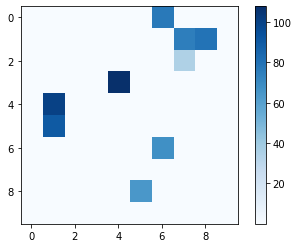

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 479.22937  +421.9846j    -180.4281   -151.0206j
   187.79271  -174.20595j     84.28117  -270.0882j
  -131.17882  -134.6171j    -106.75442   +39.012455j
  -262.25922   -38.686504j  -122.12835  +242.08612j
   -44.663586 +154.11374j     96.4201    -88.78804j  ]
 [ -35.58396   -22.529146j  -286.88318   +73.89323j
  -171.73499  +165.7142j    -174.3368   -112.5198j
   260.54477  +347.5277j      78.862434  +80.921875j
    85.51837    +4.0284433j  360.1573     -6.7069187j
  -284.69415  -206.47656j    168.59431  -324.02673j  ]
 [ 107.110565  +79.30297j    318.4427   +292.99295j
   -91.65663  -111.47005j     79.929665  -91.58487j
   119.184654 -310.77017j    -68.07777    -5.645652j
  -180.20377   -28.65471j    -45.809803  -56.429596j
  -274.07272  +321.5592j      34.999615  -88.945625j ]
 [  70.9234    -66.361275j    26.997488 -162.67294j
  -130.56187  +199.55127j   -248.44939   +70.78319j
    -0.6157604-238.53894j    135.08238  +450.80862j
   -15.588145 -201.6696j     203.18903  +201.33852j


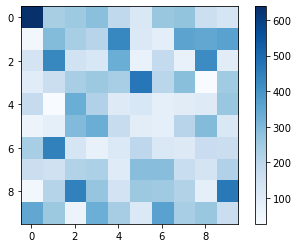

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 3) Source-finding classification

### Training labels

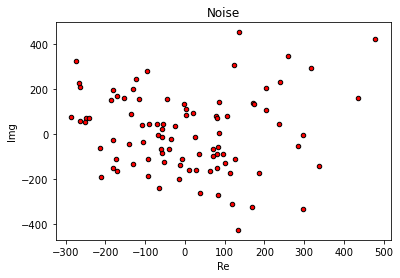

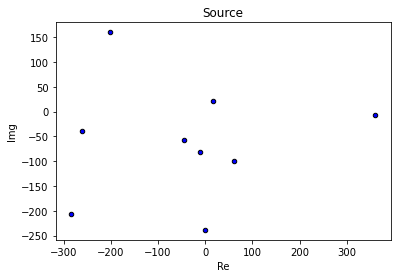

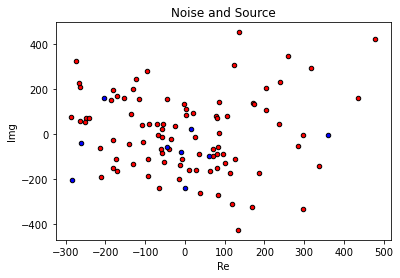

In [6]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise')
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Source')
    plt.show()
    
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise and Source')
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
plot_data(Xdata, ydata)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [7]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [8]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [9]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
indices = []
for i in range(0, len(X_data)):
    indices.append(i)
random.shuffle(indices)

for i in range(0, len(X_data)):
    X_data[i] = X_data[indices[i]]
    y_data[i] = y_data[indices[i]]

index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6 #1e-3
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, y_train, batch_size=batch_size)):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

0it [00:00, ?it/s]

Epoch:  0 | Cost: 0.164179 | Train accuracy: 0.712500 | Test Accuracy: 0.800000


2it [00:07,  3.97s/it]
0it [00:00, ?it/s]

Epoch:  1 | Loss: 0.172618 | Train accuracy: 0.675000 | Test accuracy: 0.600000


2it [00:09,  4.67s/it]
0it [00:00, ?it/s]

Epoch:  2 | Loss: 0.142092 | Train accuracy: 0.787500 | Test accuracy: 0.800000


2it [00:09,  4.71s/it]
0it [00:00, ?it/s]

Epoch:  3 | Loss: 0.128775 | Train accuracy: 0.837500 | Test accuracy: 0.800000


2it [00:09,  4.60s/it]
0it [00:00, ?it/s]

Epoch:  4 | Loss: 0.126866 | Train accuracy: 0.862500 | Test accuracy: 0.750000


2it [00:09,  4.70s/it]
0it [00:00, ?it/s]

Epoch:  5 | Loss: 0.115401 | Train accuracy: 0.925000 | Test accuracy: 0.850000


2it [00:09,  4.68s/it]
0it [00:00, ?it/s]

Epoch:  6 | Loss: 0.103649 | Train accuracy: 0.925000 | Test accuracy: 0.950000


2it [00:09,  4.62s/it]
0it [00:00, ?it/s]

Epoch:  7 | Loss: 0.116536 | Train accuracy: 0.887500 | Test accuracy: 0.900000


2it [00:09,  4.52s/it]
0it [00:00, ?it/s]

Epoch:  8 | Loss: 0.099670 | Train accuracy: 0.887500 | Test accuracy: 0.900000


2it [00:08,  4.46s/it]
0it [00:00, ?it/s]

Epoch:  9 | Loss: 0.099716 | Train accuracy: 0.962500 | Test accuracy: 1.000000


2it [00:08,  4.47s/it]


Epoch: 10 | Loss: 0.099103 | Train accuracy: 0.975000 | Test accuracy: 1.000000


### Results

Cost: 0.099103 | Train accuracy 0.975000 | Test Accuracy : 1.000000
Learned weights
Layer 0: [1.4155763  1.04226755 0.3349252 ]
Layer 1: [0.68536527 1.08744684 0.52650179]
Layer 2: [0.72267067 1.26435403 0.24959225]


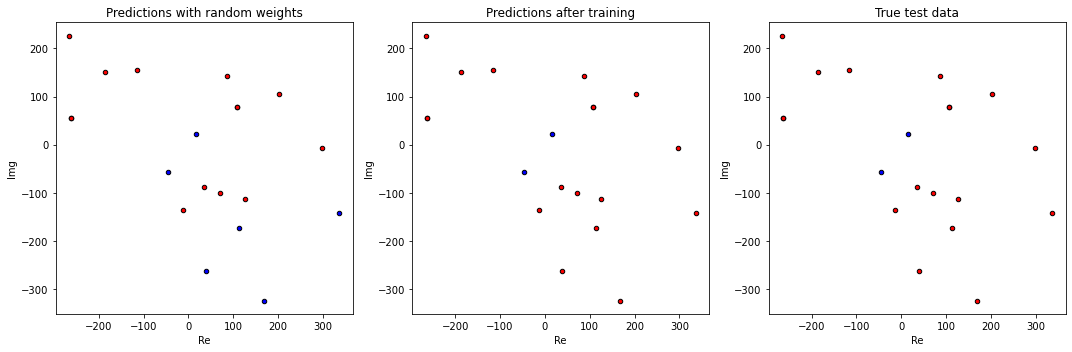

[ 0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0 -1]


In [10]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
reds = initial_predictions == 0
blues = initial_predictions == 1
axs[0].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[0].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = predicted_test == 0
blues = predicted_test == 1
axs[1].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[1].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = y_test == 0
blues = y_test == 1
axs[2].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[2].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")

axs[0].set_title("Predictions with random weights")
axs[1].set_title("Predictions after training")
axs[2].set_title("True test data")

for ax in axs.flat:
    ax.set(xlabel='Re', ylabel='Img')

plt.tight_layout()
plt.show()

print(predicted_test - initial_predictions)